# BCDA Synthetic Data Example Exploration

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/google/medical_claims_tools/blob/main/analytics/bigquery_bcda_exporation.ipynb)

This notebook contains basic examples of exploring Medicare BCDA FHIR data
in BigQuery. The results saved below are from the synthetic BCDA example data,
but this notebook can be run against any BCDA data imported into FHIR Store and
BigQuery using the `bcda_fetch` program.



## Setup


In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

from google.cloud import bigquery
bqclient = bigquery.Client(project="betazed")


Authenticated


In [ ]:
#@title Parameters
bigquery_table_prefix = "my_project.my_dataset" #@param {type:"string"}


## Some basic analytics

### Claims broken down by type

     eob_code   cnt
0         PDE  2532
1  OUTPATIENT  3658
2   INPATIENT   372
3         SNF    35
4     CARRIER  2947
5         HHA   231
6     HOSPICE    13


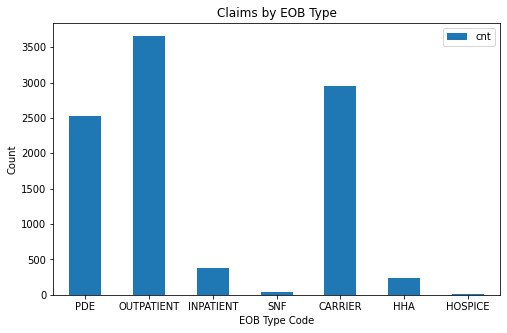

In [ ]:
query_str = """
SELECT
  (
    SELECT m.code
    FROM UNNEST(type.coding) m
    WHERE m.system = 'https://bluebutton.cms.gov/resources/codesystem/eob-type'
  ) AS eob_code,
  COUNT(*) AS cnt
FROM `{bigquery_table_prefix}.ExplanationOfBenefit`
GROUP BY eob_code
LIMIT 10;
""".format(bigquery_table_prefix=bigquery_table_prefix)
dataframe = bqclient.query(query_str).result().to_dataframe()
print(dataframe)
dataframe.plot.bar(rot=0, x="eob_code", title="Claims by EOB Type", ylabel="Count", xlabel="EOB Type Code",figsize=(8,5))

### Let's look at PDE (Pharmacy) Claims

First, note that in our example data there's only 1 item per EOB (again, needs to be verified if this is true in general). We will use this to simplify our
queries.

In [ ]:
query_str ="""
SELECT ARRAY_LENGTH(item) AS itm_len, COUNT(*) AS cnt
FROM `{bigquery_table_prefix}.ExplanationOfBenefit`
GROUP BY itm_len
""".format(bigquery_table_prefix=bigquery_table_prefix)
print(bqclient.query(query_str).result().to_dataframe())

   itm_len   cnt
0        1  9788


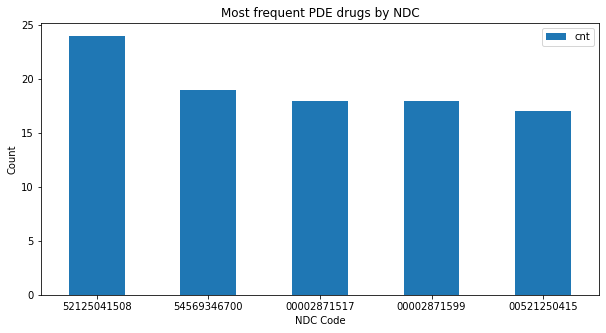

In [ ]:
# Note we assume all EOB have an item length of 1, and we only look at the 
# first coding inside the codeable concept with the NDC coding system. 
query_str = """
WITH
  PDEs AS (
    SELECT *
    FROM `{bigquery_table_prefix}.ExplanationOfBenefit`
    WHERE
      (
        SELECT m.code
        FROM UNNEST(type.coding) m
        WHERE
          m.system = 'https://bluebutton.cms.gov/resources/codesystem/eob-type'
      )
      = 'PDE'
  )
SELECT
  ARRAY(
    SELECT m.code FROM UNNEST(item[OFFSET(0)].productOrService.coding) AS m
  )[OFFSET(0)] AS ndc,
  COUNT(*) AS cnt
FROM PDEs
WHERE
  (SELECT m.system FROM UNNEST(item[OFFSET(0)].productOrService.coding) AS m)
  = 'http://hl7.org/fhir/sid/ndc'
GROUP BY ndc
ORDER BY cnt DESC
""".format(bigquery_table_prefix=bigquery_table_prefix)
dataframe = bqclient.query(query_str).result().to_dataframe()
dataframe.head().plot.bar(rot=0, x="ndc", xlabel="NDC Code", ylabel="Count", title="Most frequent PDE drugs by NDC", width=0.5, figsize=(10,5))

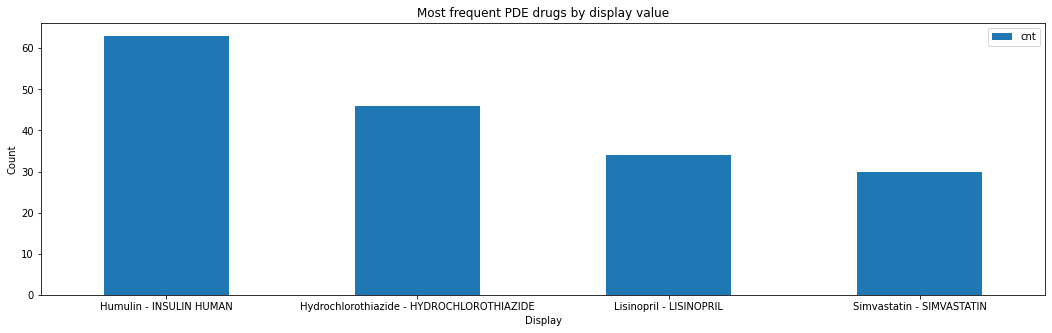

In [ ]:
query_str = """
WITH
  PDEs AS (
    SELECT *
    FROM `{bigquery_table_prefix}.ExplanationOfBenefit`
    WHERE
      (
        SELECT m.code
        FROM UNNEST(type.coding) m
        WHERE
          m.system = 'https://bluebutton.cms.gov/resources/codesystem/eob-type'
      )
      = 'PDE'
  )
SELECT
  ARRAY(
    SELECT m.display FROM UNNEST(item[OFFSET(0)].productOrService.coding) AS m
  )[OFFSET(0)] AS display,
  COUNT(*) AS cnt
FROM PDEs
WHERE
  (SELECT m.system FROM UNNEST(item[OFFSET(0)].productOrService.coding) AS m)
  = 'http://hl7.org/fhir/sid/ndc'
GROUP BY display
ORDER BY cnt DESC
""".format(bigquery_table_prefix=bigquery_table_prefix)
dataframe = bqclient.query(query_str).result().to_dataframe()
top_df = dataframe.head()
# Most frequent display value is none, so let's clip that
top_df_without_none = top_df[1:]
top_df_without_none.plot.bar(rot=0, x="display", xlabel="Display", ylabel="Count", title="Most frequent PDE drugs by display value", width=0.5, figsize=(18,5))

Kind of interesting--seems like NDCs and display values in the FHIR probably don't line up exactly. Could be an artifact of syntehtic data, or could be similar in real data. If appropirate, we can always use a sideloaded NDC dictionary. 

### Outpatient Claims


Let's take a look at the most common primary outpatient procedures. By this, I mean we only look at the 0th procedure entry per ExplanationOfBenefit. In the synthetic data, we only have one per EOB anyway--if used on non-synthetic data, this must be considered and taken into account. We also only look at procedures
coded with ICD10 to simplify.

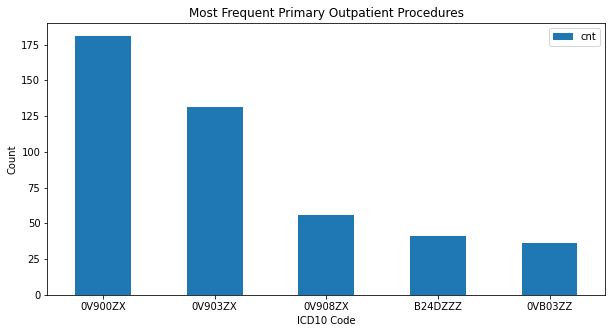

In [ ]:
query_str = """
WITH
  outpatient_claims AS (
    SELECT *
    FROM `{bigquery_table_prefix}.ExplanationOfBenefit`
    WHERE
      (
        SELECT m.code
        FROM UNNEST(type.coding) m
        WHERE
          m.system = 'https://bluebutton.cms.gov/resources/codesystem/eob-type'
      )
      = 'OUTPATIENT'
  )
SELECT
  ARRAY(
    SELECT m.code
    FROM UNNEST(procedure[OFFSET(0)].procedure.codeableConcept.coding) AS m
  )[OFFSET(0)] AS icd10,
  COUNT(*) AS cnt
FROM outpatient_claims
WHERE
  ARRAY_LENGTH(procedure) > 0
  AND (
    SELECT m.system
    FROM UNNEST(procedure[OFFSET(0)].procedure.codeableConcept.coding) AS m
  ) = 'http://hl7.org/fhir/sid/icd-10'
GROUP BY icd10
ORDER BY cnt DESC
""".format(bigquery_table_prefix=bigquery_table_prefix)
dataframe = bqclient.query(query_str).result().to_dataframe()
dataframe.head().plot.bar(rot=0, x="icd10", xlabel="ICD10 Code", ylabel="Count", title="Most Frequent Primary Outpatient Procedures", width=0.5, figsize=(10,5))

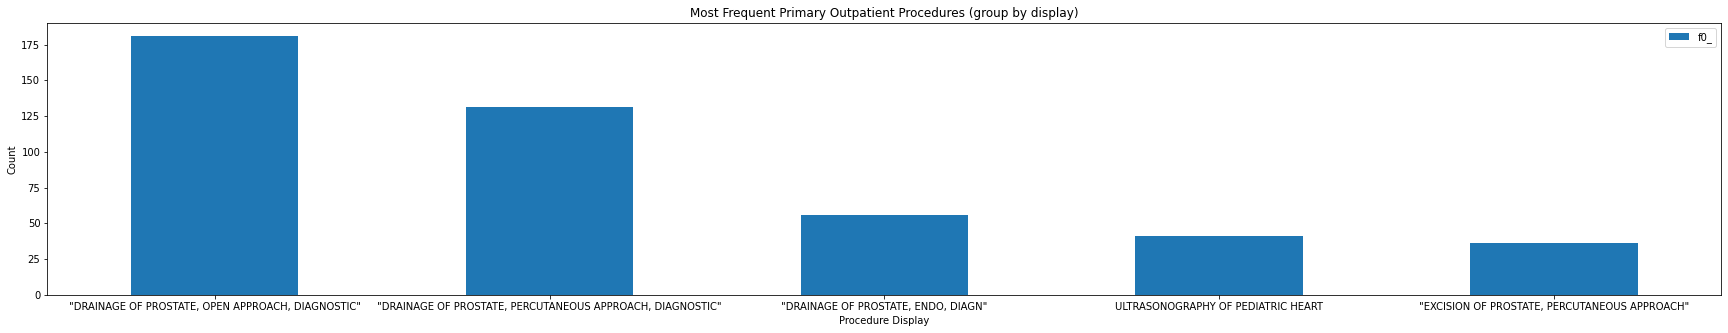

In [ ]:
query_str = """
WITH
  outpatient_claims AS (
    SELECT *
    FROM `{bigquery_table_prefix}.ExplanationOfBenefit`
    WHERE
      (
        SELECT m.code
        FROM UNNEST(type.coding) m
        WHERE
          m.system = 'https://bluebutton.cms.gov/resources/codesystem/eob-type'
      )
      = 'OUTPATIENT'
  )
SELECT
  ARRAY(
    SELECT m.display
    FROM UNNEST(procedure[OFFSET(0)].procedure.codeableConcept.coding) AS m
  )[OFFSET(0)] AS procedure_display,
  COUNT(*)
FROM outpatient_claims
WHERE
  ARRAY_LENGTH(procedure) > 0
  AND (
    SELECT m.system
    FROM UNNEST(procedure[OFFSET(0)].procedure.codeableConcept.coding) AS m
  ) = 'http://hl7.org/fhir/sid/icd-10'
GROUP BY procedure_display
ORDER BY 2 DESC
""".format(bigquery_table_prefix=bigquery_table_prefix)
dataframe = bqclient.query(query_str).result().to_dataframe()
dataframe.head().plot.bar(rot=0, x="procedure_display", xlabel="Procedure Display", ylabel="Count", title="Most Frequent Primary Outpatient Procedures (group by display)", width=0.5, figsize=(30,5))